In [21]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn import metrics
from scipy import stats
import itertools

from warnings import filterwarnings
filterwarnings('ignore')

# Thermal Conductivity

In [90]:
# Read dataset
data = pd.read_csv("../../Copper Dataset (version 4.0).csv")

# Remove duplicate columns
tc_data = data.iloc[:,-32:].drop('tensile_strength', axis=1)  # Subset of relevant features and labels
tc_data = tc_data[~tc_data.duplicated(keep='first')]  # Remove duplicates

# Split into features and target variables
X = tc_data.iloc[:,:-1]
y = tc_data['thermal_conductivity']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0., random_state=42)
X_train

,cu,pb,zn,fe,p,ag,as,o,sb,te,...,be,cr,si,ti,ca,li,b,c,nb,se
1738,95.16,0.050,0.300,0.10,0.19,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0
1824,66.50,1.400,26.000,0.35,0.00,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0
1267,63.50,1.150,35.200,0.15,0.00,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0
343,99.88,0.004,0.000,0.00,0.00,0.0,0.012,0.0,0.003,0.025,...,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0
757,99.50,1.150,0.000,0.00,0.00,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,69.00,0.070,30.988,0.05,0.00,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0
311,99.90,0.022,0.000,0.00,0.00,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0
866,97.38,0.020,1.000,0.30,0.12,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,0.01,0.0,0.0,0.0,0.000,0.0,0.0,0.0
1680,66.00,0.090,31.000,0.10,0.00,0.0,0.000,0.0,0.000,0.000,...,0.0,0.0,1.50,0.0,0.0,0.0,0.001,0.0,0.0,0.0


In [91]:
# Normalise data before PCA
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[0.95164681, 0.0125    , 0.00738007, ..., 0.        , 0.        ,
        0.        ],
       [0.6647312 , 0.35      , 0.6396064 , ..., 0.        , 0.        ,
        0.        ],
       [0.63469817, 0.2875    , 0.86592866, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.97387126, 0.005     , 0.02460025, ..., 0.        , 0.        ,
        0.        ],
       [0.6597257 , 0.0225    , 0.76260763, ..., 0.        , 0.        ,
        0.        ],
       [0.87496246, 0.0125    , 0.30504305, ..., 0.        , 0.        ,
        0.        ]])

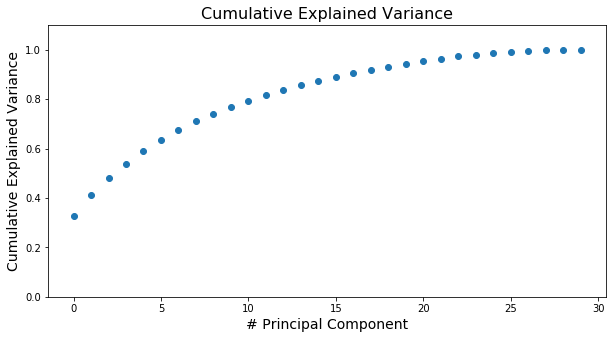

In [92]:
# Perform PCA on train data for dimensionality reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate cumulative explained variance
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Visualize the explained variance percentages
fig, ax = plt.subplots(figsize=(10,5))

# Plot the Cumulative Explained Variance Percentage for all Principal Components
ax.scatter(np.arange(len(X_train.columns)), cumulative_explained_variance_ratio)
ax.set_title("Cumulative Explained Variance", fontsize=16)
ax.set_ylabel("Cumulative Explained Variance", fontsize=14)
ax.set_xlabel("# Principal Component", fontsize=14)
ax.set_ylim([0,1.1])
plt.show()

We observe that the first 2 principal components represent the variance of most of the data!

In [93]:
# Determine the variance explained by the first k = 2 principal components
n_components = 30
explained_variance_2 = np.real(np.round(cumulative_explained_variance_ratio[n_components-1] ,5)) * 100

print("Explained variance percentage for first {} Principal Components = {}%".format(n_components, explained_variance_2))

Explained variance percentage for first 30 Principal Components = 100.0%


In [94]:
%%time
# Project data onto the k=2 Principal Components and visualise the results
pca = PCA(n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

K = []
scores = []
C = []

main_comb = (0, 1, 6, 14, 20, 15, 19, 10, 7, 28, 5, 29, 17, 25)

for k in [1,3,5,7,9]:
    for i in range(30):
        
        if i not in main_comb:
            combination = main_comb + (i,)

            model = KNeighborsRegressor(n_neighbors=k,)

            K.append(k)
            C.append(combination)

            x_train = X_train_pca[:,combination]

            model.fit(x_train, y_train)

            results = cross_validate(model, x_train, y_train, scoring='r2', cv=10)
            r2_mean = results['test_score'].mean()

            scores.append(r2_mean)

results = pd.DataFrame.from_dict({'k':K, 
                                  'Principal Components':C,
                                  'scores':scores}).sort_values(by='scores', ascending=False)

results = results[results.duplicated()]
results

Wall time: 1.31 s


,k,Principal Components,scores


In [95]:
%%time
features = results[results.scores > 0.77]['Principal Components'].values

#List Hyperparameters that we want to tune.
leaf_size = np.arange(1,50, 10)
n_neighbors = [1,3,5,7,9,11,13,15,17,19,21]
p=[1,2,3,4,5]
weights = ['distance', 'uniform']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, weights=weights, algorithm=algorithm)
#Create new KNN object
knn_2 = KNeighborsRegressor()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10, scoring='r2')
#Fit the model
best_model = clf.fit(X_train_pca[:, features[0]], y_train)

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])
print('Best weights:', best_model.best_estimator_.get_params()['weights'])
best_model.best_score_

IndexError: index 0 is out of bounds for axis 0 with size 0

In [96]:
%%time
#List Hyperparameters that we want to tune.
leaf_size = np.arange(1,50, 10)
n_neighbors = [1,3,5,7,9,11,13,15,17,19,21]
p=[1,2,3,4,5]
weights = ['distance', 'uniform']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, weights=weights, algorithm=algorithm)

ls = []
ps = []
nns = []
alg = []
wts = []
scs = []

for pcs in features:
    #Create new KNN object
    knn_2 = KNeighborsRegressor()
    #Use GridSearch
    clf = GridSearchCV(knn_2, hyperparameters, cv=10, scoring='r2')
    #Fit the model
    best_model = clf.fit(X_train_pca[:, pcs], y_train)

    
    ls.append(best_model.best_estimator_.get_params()['leaf_size'])
    ps.append(best_model.best_estimator_.get_params()['p'])
    nns.append(best_model.best_estimator_.get_params()['n_neighbors'])
    alg.append(best_model.best_estimator_.get_params()['algorithm'])
    wts.append(best_model.best_estimator_.get_params()['weights'])
    scs.append(best_model.best_score_)

Wall time: 0 ns


In [97]:
results = pd.DataFrame.from_dict({'Principal Components': features,
                                  'k': nns,
                                  'leaf_size':ls,
                                  'P':ps,
                                  'algorithm':alg,
                                  'weights':wts,
                                  'cv_mean':scs}).sort_values(by='cv_mean', ascending=False)

results.head(1).values

array([], shape=(0, 7), dtype=object)

In [98]:
r2 = []
for i in range(len(results)):
    pcs, n_neighbors, leaf_size, p, algorithm, weights, _ = results.iloc[i,:].values

    model = KNeighborsRegressor(n_neighbors=n_neighbors,
                                leaf_size=leaf_size,
                                p=p,
                                algorithm=algorithm,
                                weights=weights)

    # Prepare data
    x_train = X_train_pca[:,pcs]
    x_test = pca.transform(scaler.transform(X_test))[:, pcs]

    model.fit(x_train, y_train)

    preds = model.predict(x_test)

    r2.append(metrics.r2_score(y_test, preds))



In [100]:
76,5,"(0, 1, 6, 14, 20, 15, 19, 10, 7, 28, 5, 29, 17, 25, 16)",0.8110478928633157

(76,
 5,
 '(0, 1, 6, 14, 20, 15, 19, 10, 7, 28, 5, 29, 17, 25, 16)',
 0.8110478928633157)

In [108]:
model = KNeighborsRegressor(n_neighbors=5, leaf_size=1, p=2, weights='uniform', algorithm='ball_tree' )

best_pcomponents = (0, 1, 6, 14, 20, 15, 19, 10, 7, 28, 5, 29, 17, 25, 16)
x_train = X_train_pca[:, best_pcomponents]

cv_mean = cross_validate(model, x_train, y_train, cv=10)['test_score'].mean()
print("KNN CV score (Thermal Conductivity) = {}".format(cv_mean))

KNN CV score (Thermal Conductivity) = 0.8125150384014473


In [102]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled_pca = pca.transform(X_test_scaled)

x_test = X_test_scaled_pca[:, best_pcomponents]

model.fit(x_train, y_train)
test_preds = model.predict(x_test)

metrics.r2_score(y_test, test_preds)

0.9587708754635496

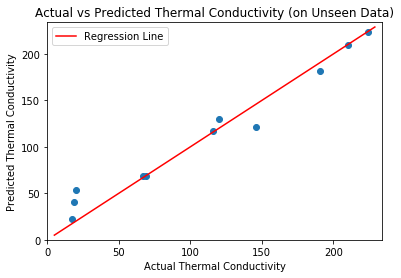

In [103]:
plt.scatter(y_test, test_preds)
plt.xlim([0,y_test.max()+10])
plt.ylim([0,y_test.max()+10])
plt.plot([5, y_test.max()+5], [5, y_test.max()+5], color='red')
plt.legend(['Regression Line'])
plt.xlabel("Actual Thermal Conductivity")
plt.ylabel("Predicted Thermal Conductivity")
plt.title("Actual vs Predicted Thermal Conductivity (on Unseen Data)")
plt.show()